## Fase 3: Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo


Utilizando un conjunto de datos que hemos compartido, se busca evaluar si existen diferencias significativas en el número de vuelos reservados según el nivel educativo de los clientes. Para ello, los pasos a seguir son:
 
1. Preparación de Datos: Filtra el conjunto de datos para incluir únicamente las columnas relevantes: 'Flights Booked' y 'Education'.

2. Análisis Descriptivo: Agrupa los datos por nivel educativo y calcula estadísticas descriptivas básicas (como el promedio, la desviación estándar, los percentiles...) del número de vuelos reservados para cada grupo.

3. Prueba Estadística: Realiza una prueba A/B TesEng para determinar si existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.


In [105]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
from scipy.stats import shapiro, kstest, poisson, chisquare, ttest_ind, levene, bartlett, sem
import scipy.stats as st
from scipy.stats import chi2_contingency, mannwhitneyu


# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames
pd.options.display.float_format = '{:.1f}'.format # para poner los números con un decimal

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Lectura fichero 
df_cust= pd.read_csv("customer_limpio.csv")

In [4]:
df_cust

,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month
0,100018,2017,1,3,0,3,1521,152.0,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.2,Standard,2016,8
1,100102,2017,1,10,4,14,2030,203.0,0,0,Canada,Ontario,Toronto,M1R 4K3,Male,College,79371.7,Single,Nova,2887.7,Standard,2013,3
2,100140,2017,1,6,0,6,1200,120.0,0,0,Canada,British Columbia,Dawson Creek,U5I 4F1,Female,College,79371.7,Divorced,Nova,2838.1,Standard,2016,7
3,100214,2017,1,0,0,0,0,0.0,0,0,Canada,British Columbia,Vancouver,V5R 1W3,Male,Bachelor,63253.0,Married,Star,4170.6,Standard,2015,8
4,100272,2017,1,0,0,0,0,0.0,0,0,Canada,Ontario,Toronto,P1L 8X8,Female,Bachelor,91163.0,Divorced,Star,6622.1,Standard,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403755,999902,2018,12,0,0,0,0,0.0,0,0,Canada,Ontario,Toronto,M1R 4K3,Male,College,79371.7,Married,Aurora,7290.1,Standard,2014,5
403756,999911,2018,12,0,0,0,0,0.0,0,0,Canada,Newfoundland,St. John's,A1C 6H9,Male,Doctor,217943.0,Single,Nova,8564.8,Standard,2012,8
403757,999940,2018,12,3,0,3,1233,123.0,0,0,Canada,Quebec,Quebec City,G1B 3L5,Female,Bachelor,47670.0,Married,Nova,20266.5,Standard,2017,7
403758,999982,2018,12,0,0,0,0,0.0,0,0,Canada,British Columbia,Victoria,V10 6T5,Male,College,79371.7,Married,Star,2631.6,Standard,2018,7


### `1. Preparación de datos`

In [45]:
cliente_book= df_cust.groupby(["loyalty_number", "education"])["flights_booked"].sum().reset_index()
cliente_book

,loyalty_number,education,flights_booked
0,100018,Bachelor,157
1,100102,College,173
2,100140,College,152
3,100214,Bachelor,79
4,100272,Bachelor,127
...,...,...,...
16732,999902,College,178
16733,999911,Doctor,0
16734,999940,Bachelor,63
16735,999982,College,22


In [46]:
df_edu_book= cliente_book[['flights_booked', 'education']]

df_edu_book

,flights_booked,education
0,157,Bachelor
1,173,College
2,152,College
3,79,Bachelor
4,127,Bachelor
...,...,...
16732,178,College
16733,0,Doctor
16734,63,Bachelor
16735,22,College


### `2. Análisis descriptivo`

**Total vuelos reservados por nivel educativo**

In [47]:
edu_booked= df_edu_book.groupby('education')['flights_booked'].sum().reset_index()
edu_booked

,education,flights_booked
0,Bachelor,1038123
1,College,426398
2,Doctor,74036
3,High School or Below,78993
4,Master,51614


**Niveles educativos: Min, max, media, mediana, desviación estandar**

In [50]:
esta_descrip = df_edu_book.groupby("education")["flights_booked"].agg(["min","max","mean","median","std","var"]).round(2)
esta_descrip


,min,max,mean,median,std,var
education,,,,,,
Bachelor,0,354,99.1,113.0,54.2,2941.1
College,0,324,100.6,113.0,54.2,2938.6
Doctor,0,292,100.9,115.0,55.9,3128.5
High School or Below,0,265,101.0,115.0,54.9,3010.4
Master,0,322,101.6,113.0,54.0,2918.5


`Análisis` no se observan diferencias significativas entre el total de reservas realizadas en cada una de las categorias. El promedio de reservas es similar al iguan que la desviación estandar

**Cuartiles para cada nivel educativo**

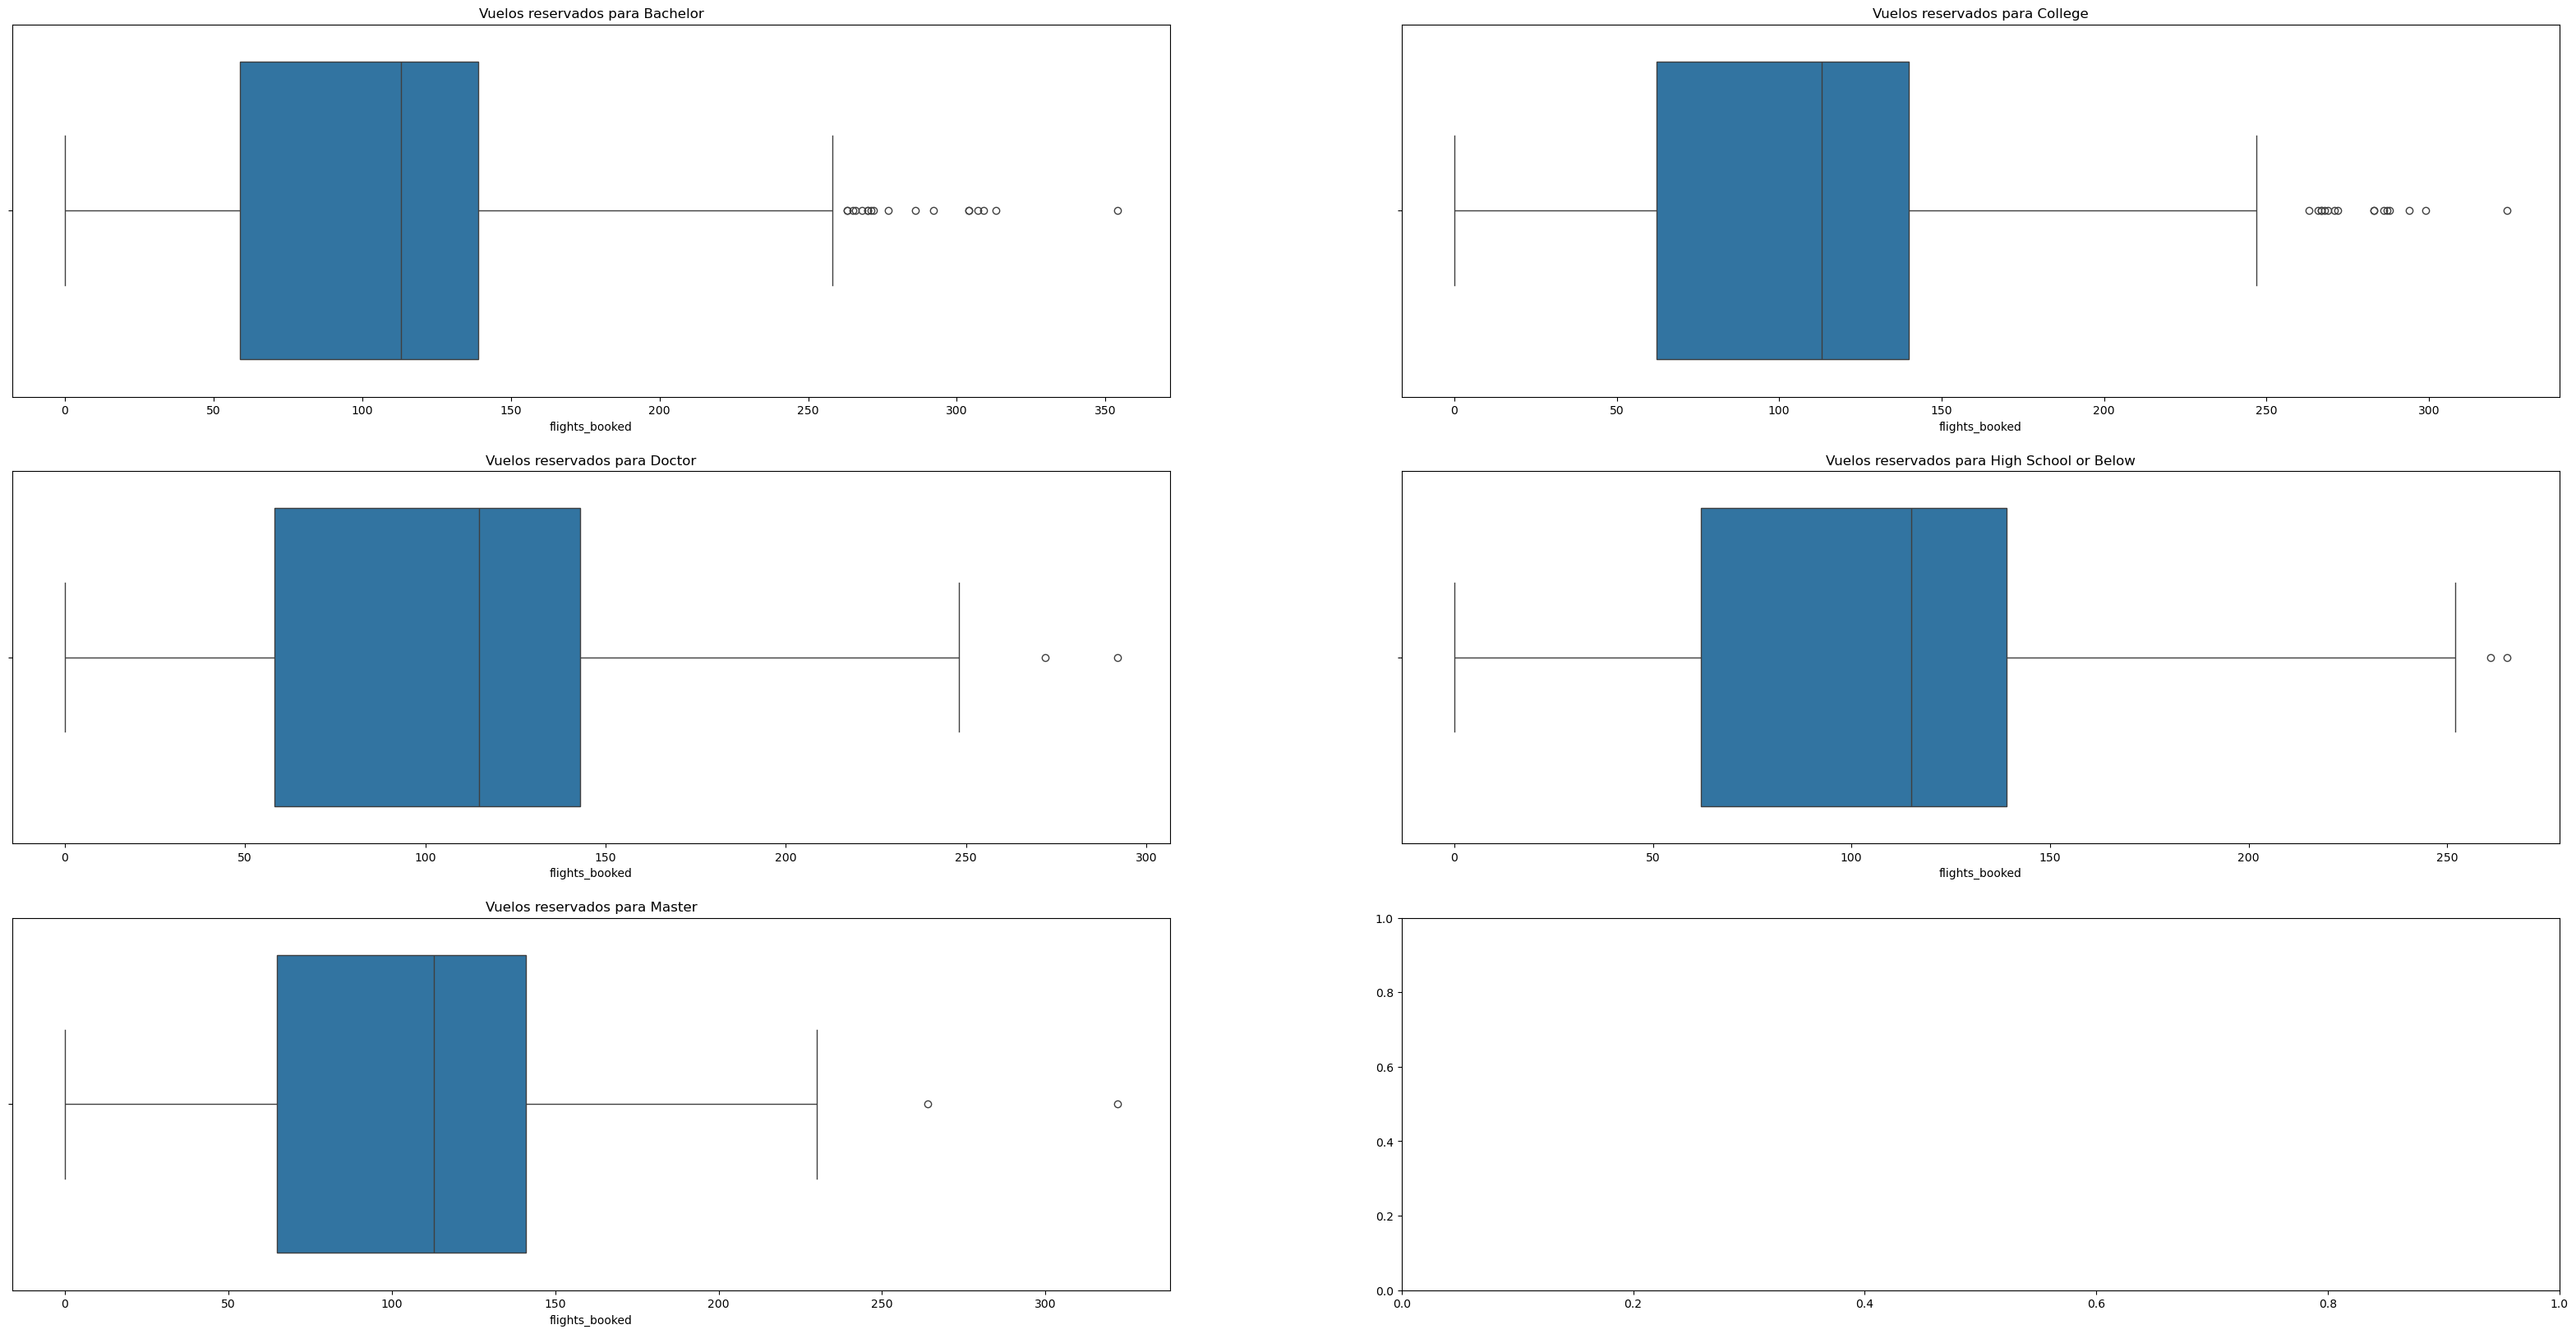

In [61]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(40, 20))

# Datos por nivel educativo
bachelor_data = df_edu_book[df_edu_book['education'] == 'Bachelor']
college_data = df_edu_book[df_edu_book['education'] == 'College']
doctor_data = df_edu_book[df_edu_book['education'] == 'Doctor']
hs_data = df_edu_book[df_edu_book['education'] == 'High School or Below']
master = df_edu_book[df_edu_book['education'] == 'Master']

# Crear un boxplot solo para "Bachelor"
sns.boxplot(x=bachelor_data['flights_booked'], ax=axes[0][0])
sns.boxplot(x=college_data ['flights_booked'], ax=axes[0][1])
sns.boxplot(x=doctor_data ['flights_booked'], ax=axes[1][0])
sns.boxplot(x=hs_data ['flights_booked'], ax=axes[1][1])
sns.boxplot(x=master ['flights_booked'], ax=axes[2][0])

# ponemos titulos a las gráficas
axes[0][0].set_title("Vuelos reservados para Bachelor")
axes[0][1].set_title("Vuelos reservados para College")
axes[1][0].set_title("Vuelos reservados para Doctor")
axes[1][1].set_title("Vuelos reservados para High School or Below")
axes[2][0].set_title("Vuelos reservados para Master")

plt.show()


`Análisis:` Hay outliers significativos en Bachelor y College, que posiblemente estén influenciando la media de vuelos reservados.

**Moda**

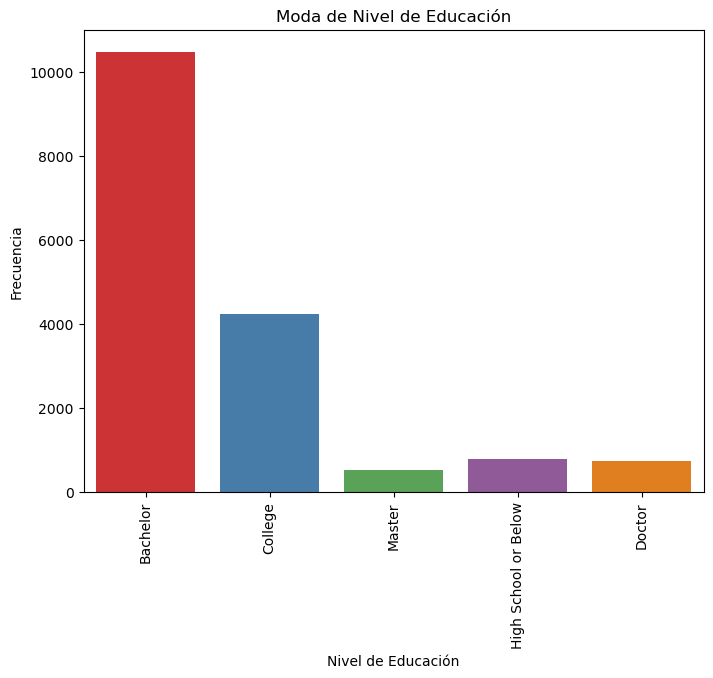

In [62]:

# establecemos el tamaño de la gráfica
plt.figure(figsize=(8, 6))

# usamos el método `countplot()` para contar cuántos datos por categoría
sns.countplot(x='education', 
              data=df_edu_book, 
              palette='Set1')

# cambiamos el nombre del eje x
plt.xlabel('Nivel de Educación')

# cambiamos el nombre del eje y
plt.ylabel('Frecuencia')

# ponemos título a la gráfica
plt.title('Moda de Nivel de Educación')

# rotamos las etiquetas del eje x si es necesario
plt.xticks(rotation=90); 

In [68]:
clientes_fre= df_edu_book.groupby("education").count()
clientes_fre["%"]=((clientes_fre["flights_booked"] / clientes_fre["flights_booked"].sum())*100).round(2)
clientes_fre

,flights_booked,%
education,,
Bachelor,10475,62.6
College,4238,25.3
Doctor,734,4.4
High School or Below,782,4.7
Master,508,3.0


`Análisis` se observa que la mayor cantidad de clientes que hacen reservas de vuelos tienen un nivel educativo Bachelor, representando el 62.6% de la muestra, seguido de aquellos que tienne un nivele educativo College

**Resultados resumidos**

In [77]:
# una vez que tengamos nuestro DataFrame preparado con todas las columnas que queremos vamos a crear una función que no haga una exploración inicial del conjunto de datos
def exploracion_dataframe(dataframe, columna_control):
        # generamos un DataFrame para los valores nulos
    print("Los nulos que tenemos en el conjunto de datos son:")
    df_nulos = pd.DataFrame(dataframe.isnull().sum() / dataframe.shape[0] * 100, columns = ["%_nulos"])
    display(df_nulos[df_nulos["%_nulos"] > 0])
    
    print("\n ..................... \n")
    print(f"Los tipos de las columnas son:")
    display(pd.DataFrame(dataframe.dtypes, columns = ["tipo_dato"]))
    
    
    print("\n ..................... \n")
    print("Los valores que tenemos para las columnas categóricas son: ")
    dataframe_categoricas = dataframe.select_dtypes(include = "O")
    
    for col in dataframe_categoricas.columns:
        print(f"La columna {col.upper()} tiene las siguientes valore únicos:")
        display(pd.DataFrame(dataframe[col].value_counts()).head())    
    
    #Comparacion entre los niveles educativos    
    for categoria in dataframe[columna_control].unique():
        
        dataframe_filtrado = dataframe[dataframe[columna_control] == categoria]
    
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas categóricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe(include = "O").T)
        
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas numéricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe().T)

In [78]:
exploracion_dataframe(df_edu_book,"education")

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
flights_booked,int64
education,object



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna EDUCATION tiene las siguientes valore únicos:


,count
education,
Bachelor,10475
College,4238
High School or Below,782
Doctor,734
Master,508



 ..................... 

Los principales estadísticos de las columnas categóricas para el BACHELOR son: 


,count,unique,top,freq
education,10475,1,Bachelor,10475



 ..................... 

Los principales estadísticos de las columnas numéricas para el BACHELOR son: 


,count,mean,std,min,25%,50%,75%,max
flights_booked,10475.0,99.1,54.2,0.0,59.0,113.0,139.0,354.0



 ..................... 

Los principales estadísticos de las columnas categóricas para el COLLEGE son: 


,count,unique,top,freq
education,4238,1,College,4238



 ..................... 

Los principales estadísticos de las columnas numéricas para el COLLEGE son: 


,count,mean,std,min,25%,50%,75%,max
flights_booked,4238.0,100.6,54.2,0.0,62.2,113.0,140.0,324.0



 ..................... 

Los principales estadísticos de las columnas categóricas para el MASTER son: 


,count,unique,top,freq
education,508,1,Master,508



 ..................... 

Los principales estadísticos de las columnas numéricas para el MASTER son: 


,count,mean,std,min,25%,50%,75%,max
flights_booked,508.0,101.6,54.0,0.0,65.0,113.0,141.0,322.0



 ..................... 

Los principales estadísticos de las columnas categóricas para el HIGH SCHOOL OR BELOW son: 


,count,unique,top,freq
education,782,1,High School or Below,782



 ..................... 

Los principales estadísticos de las columnas numéricas para el HIGH SCHOOL OR BELOW son: 


,count,mean,std,min,25%,50%,75%,max
flights_booked,782.0,101.0,54.9,0.0,62.0,115.0,139.0,265.0



 ..................... 

Los principales estadísticos de las columnas categóricas para el DOCTOR son: 


,count,unique,top,freq
education,734,1,Doctor,734



 ..................... 

Los principales estadísticos de las columnas numéricas para el DOCTOR son: 


,count,mean,std,min,25%,50%,75%,max
flights_booked,734.0,100.9,55.9,0.0,58.2,115.0,143.0,292.0


### `3. Prueba estadística`

Realiza una prueba A/B Testing para determinar si existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.

**1. Prueba de normalidad**

In [83]:
# Usamos  Kolmogorov-Smirnov al tener más de 50 datos

def normalidad(dataframe, columna):
    # Realizar la prueba KS con una distribución normal
    statistica_ks, p_valor = stats.kstest(dataframe[columna], 'norm')

    # Resultados
    print("Estadística KS:", statistica_ks)
    print("P-Valor:", p_valor)

    if p_valor < 0.05:
        print("Los datos no siguen una distribución normal.")
    else:
        print("Los datos siguen una distribución normal.")

# Realizar la prueba
normalidad(df_edu_book, "flights_booked")


    

Estadística KS: 0.9057421734268153
P-Valor: 0.0
Los datos no siguen una distribución normal.


**2. Prueba de homogeneidad**

In [87]:

def homogeneidad (dataframe, columna, columna_metrica):
        
    # lo primero que tenemos que hacer es crear tantos conjuntos de datos para cada una de las categorías que tenemos, Control Campaign y Test Campaign
    valores_evaluar = []
    
    for valor in dataframe[columna].unique():
        valores_evaluar.append(dataframe[dataframe[columna]== valor][columna_metrica])

    statistic, p_value = stats.levene(*valores_evaluar)
    if p_value > 0.05:
        print(f"Para la métrica {columna_metrica} las varianzas son homogéneas entre grupos.")
    else:
        print(f"Para la métrica {columna_metrica}, las varianzas no son homogéneas entre grupos.")


homogeneidad(df_edu_book ,'education', "flights_booked")

Para la métrica flights_booked las varianzas son homogéneas entre grupos.


**3. Prueba chi cuadrado**

In [94]:
# Crear una tabla de contingencia por nivel educativo
tabla_contingencia = df_edu_book.groupby('education')[['flights_booked']].sum()

# Mostrar la tabla de contingencia
print("\nTabla de Contingencia:")
print(tabla_contingencia)

# Realizar la prueba de Chi Cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_contingencia) # la ponderación es global mas allá del análisis por columna.

# Mostrar resultados
print("\nResultados de la prueba de Chi Cuadrado:")
print(f"Chi cuadrado: {chi2}")
print(f"Valor p: {p}")
print(f"Grados de libertad: {dof}")
print("\nTabla esperada:")
print(expected)

# Conclusión
if p > 0.05:
    print("\nConclusión: No hay relación entre los distintos niveles educativos, son independiente")
else:
    print("\nConclusión: Hay una relación entre los distintos niveles educativos, son independiente.")


Tabla de Contingencia:
                      flights_booked
education                           
Bachelor                     1038123
College                       426398
Doctor                         74036
High School or Below           78993
Master                         51614

Resultados de la prueba de Chi Cuadrado:
Chi cuadrado: 0.0
Valor p: 1.0
Grados de libertad: 0

Tabla esperada:
[[1038123.]
 [ 426398.]
 [  74036.]
 [  78993.]
 [  51614.]]

Conclusión: No hay relación entre los distintos niveles educativos, son independiente


### 4. Prueba de comprobación 

Los resultados obtenidos hasta el momento son:

    1. Los grupos por nivel educativo NO tienen una distribución normal
    2. Las varianzas son homogeneas entre los grupos 
    3. Hay independencia entre los datos de los niveles educativos

Ante esto se decide realizar la prueba de Mann-Whitney, ya que los datos no cumplen con los supuestos de normalidad y son grupos independientes

In [103]:
# Función para aplicar la prueba

def man_whitney(dataframe, grupo_A, grupo_B, columna_metrica, columna_grupos="education"):
    
    # Filtramos los datos por los grupos educativos 
    data_A = dataframe[dataframe[columna_grupos] == grupo_A][columna_metrica]
    data_B = dataframe[dataframe[columna_grupos] == grupo_B][columna_metrica]


    # Realizar la prueba de Mann-Whitney
    estadistico, p_value = mannwhitneyu(data_A, data_B)

    # Imprimir resultados
    print(f'Estadístico U: {estadistico}')
    print(f'Valor p: {p_value}')

    # Interpretar resultados
    if p_value < 0.05:
        print(f"Hay diferencias significativas en {columna_metrica} entre {grupo_A} y {grupo_B}.\n")
    else:
        print(f"No hay diferencias significativas en {columna_metrica} entre {grupo_A} y {grupo_B}.\n")


# Llamada a la función para comparar dos niveles educativos
man_whitney(df_edu_book, "Bachelor", "Doctor", "flights_booked")
man_whitney(df_edu_book, "Bachelor", "College", "flights_booked")
man_whitney(df_edu_book, "Bachelor", "Master", "flights_booked")
man_whitney(df_edu_book, "Bachelor", "High School or Below", "flights_booked")
man_whitney(df_edu_book, "Doctor", "College", "flights_booked")
man_whitney(df_edu_book, "Doctor", "Master", "flights_booked")
man_whitney(df_edu_book, "Doctor", "High School or Below", "flights_booked")
man_whitney(df_edu_book, "Master", "High School or Below", "flights_booked")
man_whitney(df_edu_book, "Master", "College", "flights_booked")
man_whitney(df_edu_book, "High School or Below", "College", "flights_booked")

Estadístico U: 3735186.0
Valor p: 0.19763599432091572
No hay diferencias significativas en flights_booked entre Bachelor y Doctor.

Estadístico U: 21920646.0
Valor p: 0.23684915655713712
No hay diferencias significativas en flights_booked entre Bachelor y College.

Estadístico U: 2601362.5
Valor p: 0.39541849522673045
No hay diferencias significativas en flights_booked entre Bachelor y Master.

Estadístico U: 4019380.5
Valor p: 0.3836293851920295
No hay diferencias significativas en flights_booked entre Bachelor y High School or Below.

Estadístico U: 1579152.5
Valor p: 0.5071592865610365
No hay diferencias significativas en flights_booked entre Doctor y College.

Estadístico U: 187482.0
Valor p: 0.8663432168169858
No hay diferencias significativas en flights_booked entre Doctor y Master.

Estadístico U: 290222.5
Valor p: 0.7045704612516628
No hay diferencias significativas en flights_booked entre Doctor y High School or Below.

Estadístico U: 199464.5
Valor p: 0.8982070210855677
No ha

#### `Conclusión` No existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos
